# Chess Games Data Analysis

In this notebook, I am going to do an analysis on a dataset of chess games that were played on Lichess. The dataset can be downloaded from https://www.kaggle.com/mysarahmadbhat/online-chess-games

I will do some exploratory data analysis to try to uncover some trends for common first moves by the white pieces. Afterwards, I will explore the following questions:

- How big of an advantage do white pieces actually have, if any?
- How does rating affect who wins?
- Are there are players in this dataset with a suspiciously high win rate? Could they be cheating?

With the help of the stockfish module, we can hopefully answer the third question from that list. All analysis of the game will be done using the latest verion (at this time, of course) of Stockfish, Stockfish 14.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stockfish import Stockfish

stockfish = Stockfish('C:/Users/cbarg/Downloads/stockfish_14_win_x64_avx2/stockfish_14_win_x64_avx2/stockfish_14_x64_avx2.exe')
stockfish.set_elo_rating(2600)
df = pd.read_csv('chess_games.csv')

Before we begin analysis, let's see what kind of data we're dealing with here. We might have to add some columns to help with analysis, or clean the data a bit.

In [2]:
print(df.dtypes)
df.head(1)

game_id               int64
rated                  bool
turns                 int64
victory_status       object
winner               object
time_increment       object
white_id             object
white_rating          int64
black_id             object
black_rating          int64
moves                object
opening_code         object
opening_moves         int64
opening_fullname     object
opening_shortname    object
opening_response     object
opening_variation    object
dtype: object


,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation


## Adding columns, separating data by opening

In the next cell, I am going to add a few columns to the dataFrame that will be helpful in the analysis of the data. For example, the moves are given in one long string, which could prove to be hard to access if we are searching for a move number in particular. To make it easier for us, we can turn this string into a list.

Since we are also interested in how rating affects the outcome of the games, we might want a column telling us the rating difference between the players, and another column telling us whether or not the higher-rated player won. Other columns have been added as needed.

Additionally, I've created four new DataFrames based on four common opening moves by white. The frequency with which these opening moves are used are visualized in a pie chart below the next cell.

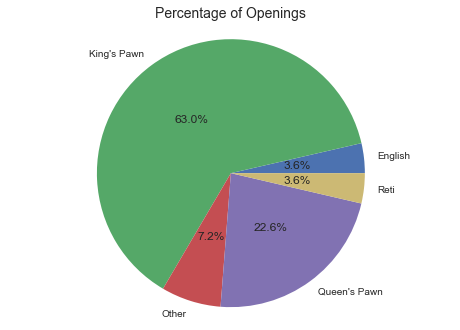

In [3]:
#Getting rid of all of the games that are only a few moves
df = df[df.turns >= 3]

#Making a new Series in the dataframe to contain a list of all the moves, since the move list as a string is not all that useful to us
df['moves_list'] = df.moves.apply(lambda x: x.split())

#Add columns called opening_move and response, which are the first moves by white and black, respectively
df['opening_move'] = df.moves_list.apply(lambda x: x[0])
df['response'] = df.moves_list.apply(lambda x: x[1])

#Adding an opening_name column to name a few common opening moves
df['opening_name'] = df.moves_list.apply(lambda x: 'King\'s Pawn' if x[0] == 'e4' else ('Queen\'s Pawn' if x[0] == 'd4' else ('English' if x[0] == 'c4' else ('Reti' if x[0] == 'Nf3' else 'Other'))))

#What was the rating gap between the two players?
df['rating_gap'] = abs(df['white_rating'] - df['black_rating'])

#Did the higher-rated player win?
df['higher_rated_victory'] = np.where((df['winner'] == 'White') & (df['white_rating'] > df['black_rating']) | (df['winner'] == 'Black') & (df['black_rating'] > df['white_rating']), 1, 0)

#Classify the rating gap. This will be used later when we want to visualize what affect greater rating gaps have on the victory rate of higher-rated players
df['rating_gap_class'] = df.rating_gap.apply(lambda x: '0-50' if (x <= 50) else ('51-100' if (x > 50 and x <= 100) else ('101-150' if (x > 100 and x <= 150) else ('151-200' if (x > 150 and x <= 200) else ('201-250' if (x > 200 and x <= 250) else '>250')))))

#Did white win?
df['white_victory'] = np.where(df['winner'] == 'White', 1, 0)

#Split into four of the most popular openings by white
english = df[df.opening_move == 'c4']
queens_pawn = df[df.opening_move == 'd4']
kings_pawn = df[df.opening_move == 'e4']
reti = df[df.opening_move == 'Nf3']

#Visualize which openings are used the most
opening_data = df.groupby('opening_name')['game_id'].count()
plt.pie(x=opening_data, autopct='%.1f%%', labels=opening_data.keys(), pctdistance=0.5)
plt.title('Percentage of Openings', fontsize=14)
plt.axis('equal') #ensures pie chart is a circle
plt.show()
plt.clf()

Okay, cool. Since we are interested in seeing what sort of effect being the white or black pieces can have on your chances of winning, let's take a look at that data for each of the four common openings.

# Is there a color advantage by opening?

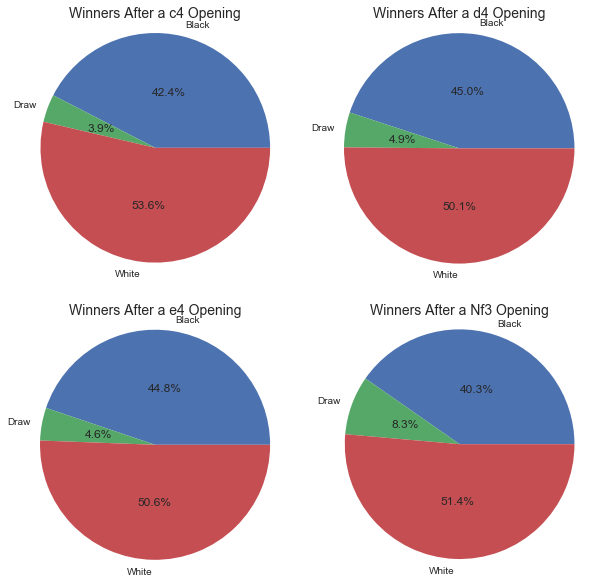

In [4]:
#Visualize who was able to win after each opening using pie chart

#For each DataFrame, create additional DataFrame counting the number of times white or black won (or drew)
english_winner_data = english.groupby('winner')['game_id'].count()
queen_winner_data = queens_pawn.groupby('winner')['game_id'].count()
king_winner_data = kings_pawn.groupby('winner')['game_id'].count()
reti_winner_data = reti.groupby('winner')['game_id'].count()

pie, axs = plt.subplots(2,2, figsize=[10,10])

plt.subplot(2,2,1)
plt.pie(x=english_winner_data, autopct="%.1f%%", labels=english_winner_data.keys(), pctdistance=0.5)
plt.title("Winners After a c4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,2)
plt.pie(x=queen_winner_data, autopct="%.1f%%", labels=queen_winner_data.keys(), pctdistance=0.5)
plt.title("Winners After a d4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,3)
plt.pie(x=king_winner_data, autopct="%.1f%%", labels=king_winner_data.keys(), pctdistance=0.5)
plt.title("Winners After a e4 Opening", fontsize=14)
plt.axis('equal')

plt.subplot(2,2,4)
plt.pie(x=reti_winner_data, autopct="%.1f%%", labels=reti_winner_data.keys(), pctdistance=0.5)
plt.title("Winners After a Nf3 Opening", fontsize=14)
plt.axis('equal')
plt.show()

# How often does the higher-rated player win?

Let's first try to visualize this by opening, like we did with the white/black piece victory rate. I'll do this by counting the total number of games where the higher-rated player was victorious, and then adding columns for the total number of games played and games that were either drawn or lost by the higher-rated player.

In [19]:
#Creating a DataFrame to tell me the total amount of wins by the white pieces in four common openings

#Counts the total amount of white piece victories, grouped by opening name
df_grouped_ratings = df.groupby('opening_name')['higher_rated_victory'].sum()
df_grouped_ratings = df_grouped_ratings.to_frame() #Converting from series to dataFrame

#Adding a column for the total number of games
df_grouped_ratings['totals'] = df.groupby('opening_name')['higher_rated_victory'].count()
#Adding a column for draws/losses
df_grouped_ratings['losses_or_draws'] = df_grouped_ratings['totals'] - df_grouped_ratings['higher_rated_victory']
print(df_grouped_ratings.head(10))

              higher_rated_victory  totals  losses_or_draws
opening_name                                               
English                        426     714              288
King's Pawn                   7626   12499             4873
Other                          915    1434              519
Queen's Pawn                  2798    4486             1688
Reti                           424     722              298


I want some sort of visual evidence to indicate whether or not white is completely dominant over black or not. I've grouped these by four common openings to see whether or not openings might have an affect on the outcome of the game.

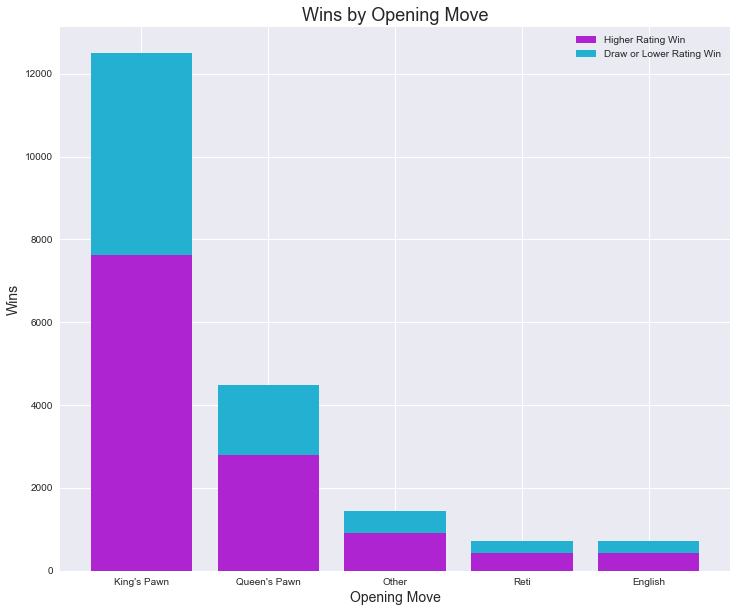

In [22]:
#Visualize which ratings dominate which opening
df_grouped_ratings = df_grouped_ratings.sort_values('totals', ascending=False)
fig, ax = plt.subplots(1, figsize=(12,10))
ax.bar([0,1,2,3,4], df_grouped_ratings['higher_rated_victory'], label='Higher Rating Win', color='#ae24d1', tick_label=df_grouped_ratings.index)
ax.bar([0,1,2,3,4], df_grouped_ratings['losses_or_draws'], label='Draw or Lower Rating Win', bottom=df_grouped_ratings['higher_rated_victory'], color='#24b1d1')
ax.set_ylabel('Wins', fontsize=14)
ax.set_xlabel('Opening Move', fontsize=14)
ax.set_title('Wins by Opening Move', fontsize=18)
ax.legend()
plt.show()

Looking at the barplot, we can see that the higher-rated player has a slight advantage in just about every opening.

# White's Victory Rate by Response by Opening

Below I've plotted barplots coresponding to the winning rate of the white pieces when black makes the move indicated on the x-axis.

I've included all of the response moves in the dataset, so some of the lesser-used (and frankly, terrible) moves by black are seen in the plots. Since these are used so little, the error bars are gigantic. The further you get to the right on each plot, the rarer the move, and the bigger the error bar.

Again, I've done these plots for four common first moves by the white pieces.

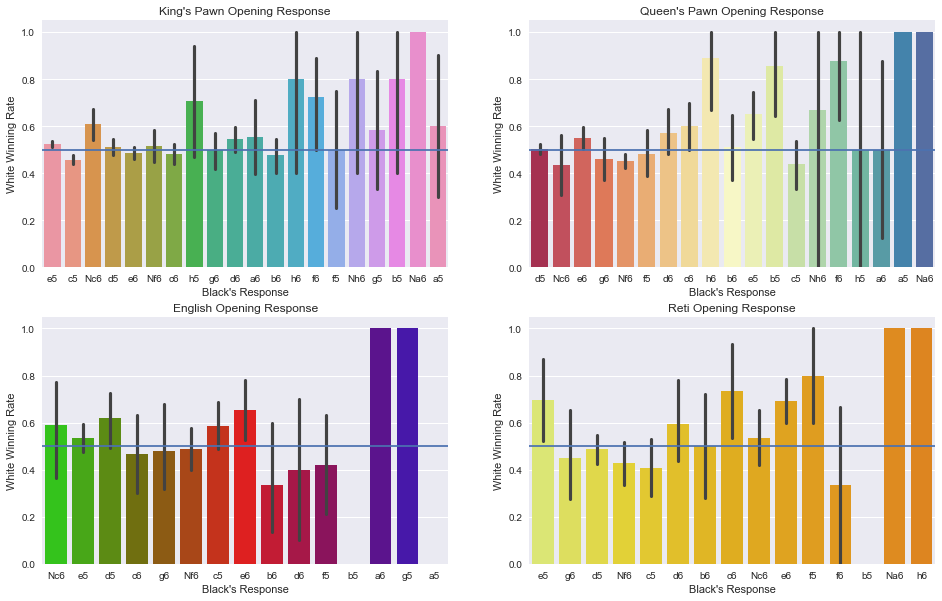

In [23]:
plt.clf()
pie, axs = plt.subplots(2,2, figsize=[16,10])

plt.subplot(2,2,1)
sns.barplot(
    data=kings_pawn,
    x='response',
    y='white_victory',
    #palette='paired'
)
plt.title('King\'s Pawn Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,2)
sns.barplot(
    data=queens_pawn,
    x='response',
    y='white_victory',
    palette='Spectral'
)
plt.title('Queen\'s Pawn Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,3)
sns.barplot(
    data=english,
    x='response',
    y='white_victory',
    palette='brg_r'
)
plt.title('English Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.subplot(2,2,4)
sns.barplot(
    data=reti,
    x='response',
    y='white_victory',
    palette='Wistia'
)
plt.title('Reti Opening Response')
plt.ylabel('White Winning Rate')
plt.xlabel('Black\'s Response')
plt.axhline(0.5)

plt.show()
plt.clf()

At this point I think we can be fairly confident that being the white pieces in chess gives you *some* statistical advantage. After all, white pieces go first, and essentially control the flow of the game until a grave mistake is made. If no mistakes are made, then everything black does is just in response to whatever white does.

But certainly, rating also comes into play right? The lower your rating is, the more likely you are to make one of these mistakes (and that's completely fine).

We should try grouping the games by rating to see what kind of effect it will have on the outcomes of the games.

## Does having white offer a particular advantage based on rating?

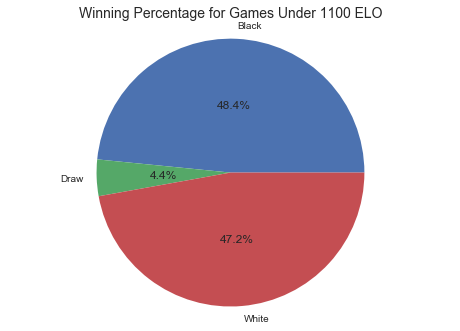

In [27]:
#Create desired dataframe where every player is rated under a certain ELO

#This mainly became a cell for me to mess around with the numbers a bit then
#see how it affected the pie chart
num = 1100
df_under_num = df[(df.white_rating < num) & (df.black_rating < num)]

df_under_num_winners = df_under_num.groupby('winner')['game_id'].count()
df_under_num_winners

plt.pie(x=df_under_num_winners, autopct="%.1f%%", labels=df_under_num_winners.keys(), pctdistance=0.5)
plt.title("Winning Percentage for Games Under {} ELO".format(num), fontsize=14)
plt.axis('equal')
plt.show()

Well, if anything, it's fun to mess with the 'num' variable. For example, if you set it to 1100, the black pieces actually have a higher winning rate than the white pieces.

# How does rating gap affect who wins?
I think the answer to this question should be fairly simple. Our intuition might tell us that the higher-rated person would win a majority of the time. The more the rating gap between two players is, the higher the chance the higher-rated player will win. I can see this type of data being used in many ways, however. For instance, if a lower-rated player has many wins against someone with a significantly higher than them, it could be a red flag that they're using an engine to cheat. other variables would need to be looked at though. Are those games rated? Were the wins against the same person? If the answers are no then yes, in all likelihood a lower-rated player could just be practicing against a higher-rted friend. If yes then no, maybe the person is cheating. If yes then yes, perhaps someone is intentionally giving up points to someone else.

There are many possibilities.

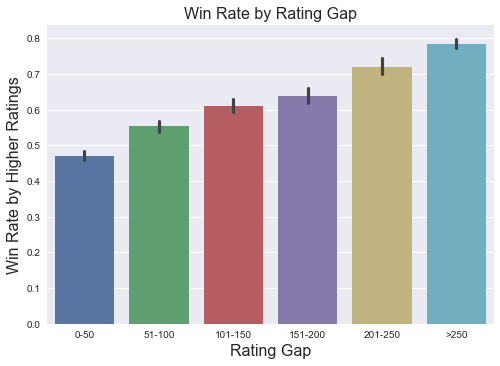

In [28]:
sns.barplot(
    data=df,
    x='rating_gap_class',
    y='higher_rated_victory',
    order=['0-50', '51-100', '101-150', '151-200', '201-250', '>250'],
    #palette='mako' This palette didn't exist anymore when I transferred this code from kaggle to jupyter :(
)
plt.xlabel('Rating Gap', fontsize=16)
plt.ylabel('Win Rate by Higher Ratings', fontsize=16)
plt.title('Win Rate by Rating Gap', fontsize=16)
plt.show()
plt.clf()

As expected, the higher the rating gap, the higher the probability that the person with the higher rating wins.

# Anybody with a particularly high amount of wins? What about win rate?

In [73]:
#Get a DataFrame of all users who played white pieces and how many wins they accrued
df_users_white = df.groupby('white_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_users_white.rename(columns={'white_victory':'white_victories', 'game_id':'white_games'}, inplace=True)
df_users_white = df_users_white.set_index('white_id')

#Get a DataFrame of all users who had black pieces and how many victories their opponents accrued
df_users_black = df.groupby('black_id',as_index=False).agg({'white_victory':'sum', 'game_id':'count'})
df_users_black.rename(columns={'white_victory':'white_victories', 'game_id':'black_games'}, inplace=True)
df_users_black = df_users_black.set_index('black_id')

#Since we only know white piece victories, we need black piece victories to give us the number of games won by the key
df_users_black['black_victories'] = df_users_black.black_games - df_users_black.white_victories
df_users_black.drop('white_victories', axis=1, inplace=True)

#Join the two dataframes together on the index (username in this case). Some will have NaN values because of the nature of the join
#But we can just replace those with 0
df_users = df_users_white.join(df_users_black)
df_users = df_users.fillna(0)

#add columns for total victories and total games played
df_users['victories'] = df_users.white_victories + df_users.black_victories
df_users['games_played'] = df_users.white_games + df_users.black_games

#Now that we have total number of wins and games played, how about winning percentage?
df_users['win_pct'] = df_users.victories / df_users.games_played


#Let's sort the df by people who have the highest win percentage
df_users_sorted = df_users.sort_values(by=['win_pct'], ascending=False)
df_users_sorted.head(5)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
rahza,1,1,0.0,0.0,1.0,1.0,1.0
houdini1ply,2,2,0.0,0.0,2.0,2.0,1.0
pakz91,1,1,0.0,0.0,1.0,1.0,1.0
holger1111,1,1,0.0,0.0,1.0,1.0,1.0
hola_yehmi,1,1,0.0,0.0,1.0,1.0,1.0


We now have a *possible* list of cheaters listed up above. However, the names displayed really didn't play that many games, so there is a good chance these users played fair and square.

Let's try to filter the number of games played by the users to see if we can spot any possible cheaters.


In [76]:
game_threshold = 24
df_users_many_games = df_users[(df_users.games_played >= game_threshold)]
df_users_many_games_sorted = df_users_many_games.sort_values(by=['win_pct'], ascending=False)
df_users_many_games_sorted.head(10)

,white_victories,white_games,black_games,black_victories,victories,games_played,win_pct
white_id,,,,,,,
chesswithmom,14,14,10.0,10.0,24.0,24.0,1.000000
siindbad,13,13,13.0,13.0,26.0,26.0,1.000000
smartduckduckcow,3,3,21.0,21.0,24.0,24.0,1.000000
chesscarl,18,18,28.0,27.0,45.0,46.0,0.978261
lzchips,12,13,13.0,13.0,25.0,26.0,0.961538
christina-a-11,14,15,11.0,11.0,25.0,26.0,0.961538
smilsydov,15,16,22.0,21.0,36.0,38.0,0.947368
doraemon61,18,19,23.0,21.0,39.0,42.0,0.928571
gmanderson,12,12,12.0,10.0,22.0,24.0,0.916667


Okay, **now** we might have found some cheaters. Let's further analyze their data to see what they're up to. The list of possible cheaters is not limited to just the names shown, to be clear. I just displayed the top 10 users who played 24 games or more.

# Cheater Case Study

I am going to pick a particularly fishy player from our list of people above. Let's take a look at the user **chesscarl** based on the fact that they won 45 out of 46 games played in this set of data.

In [77]:
#Get a DataFrame containing all of the games chesscarl played
df_carl = df[(df.white_id == 'chesscarl') | (df.black_id == 'chesscarl')]
df_carl.rated.unique()

array([ True])

A quick glance at the DataFrame tells us that all the games chesscarl has played were rated games, meaning ELO points were on the line. This tells me that there are three possibilities:
- chesscarl is cheating
- chesscarl created a smurf account, and is quickly climbing the ratings
- chesscarl is grabbing ELO points from a friend

Or it could be something completely different, I wouldn't know. We can take a look at the opponents chesscarl played to try to rule out the third option:

In [78]:
#Get all the unique ids in the games chesscarl has played
print(df_carl.white_id.unique())
print(df_carl.black_id.unique())

['chilon' 'loebas' 'thelordoftheboard' 'lebbeusz2450' 'chesscarl'
 'angel2006' 'aca021' 'rigoberto_22' 'heisenberg3' 'vchess4' 'slobodan7'
 'fire_on_the_board' 'rodrigo-sagastegui' 'bdoq' 'hayki34' 'klemi'
 'mavrincbor' 'peshkach' 'ibonuribeetxebarria' 'foucheval' 'comped'
 'bshma' 'thorfabian' 'oilen1401' 'mahyir35' 'superii']
['chesscarl' 'christopho' 'kiterdekel' 'a_b_d_o' 'angel2006'
 'mario-panagiotis' 'grosschess' 'danielsor' 'sergey197316' 'anna1605'
 'wevertonsoares' 'withouttroble' 'g_king' 'krembrule' 'grewia'
 'ratnikmora' 'just_emza' 'gfinch' 'mahyir35']


Since there are many different accounts chesscarl played against, it's unlikely the third option is true, so we can rule that out. Let's take a look at a few more things.

In [79]:
#In how many games was chesscarl the higher-rated player? Adding a column to tell us whether they were or not
df_carl['carl_higher'] = np.where((df_carl['white_id'] == 'chesscarl') & (df_carl['white_rating'] > df_carl['black_rating']) | (df_carl['black_id'] == 'chesscarl') & (df_carl['black_rating'] > df_carl['white_rating']), 1, 0)

#df_carl[['white_id', 'white_rating', 'black_id', 'black_rating', 'carl_higher', 'rating_gap']].head(10)

#We can get the number of games that chesscarl was rated higher than their opponents by using the .sum() function on the dataframe
df_carl.carl_higher.sum()

C:\Users\cbarg\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


43

So it looks like chesscarl was the higher-rated player in 43 out of the 46 games they played. This might account for their extraordinary amount of wins. As one last check, let's see what the average rating gap between the two players were in both the games carl was higher-rated and lower-rated.

In [81]:
df_carl_is_higher = df_carl[(df_carl.carl_higher == 1)]
df_carl_is_lower = df_carl[(df_carl.carl_higher == 0)]

print('Average rating above opponents when higher-rated:', df_carl_is_higher.rating_gap.mean())
print('Average rating below opponents when lower-rated:', df_carl_is_lower.rating_gap.mean())

Average rating above opponents when higher-rated: 355.48837209302326
Average rating below opponents when lower-rated: 68.0


Hmm, so it looks like this 'Carl' character got most of their wins by bullying players at a much lower rating. When Carl's opponents had a higher rating (which was only in 3 games) they averaged 68 points higher. When Carl was the higher-rated player, Carl was, on average, 355 points above their opponent.

In [82]:
df.shape

(19855, 25)